In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
from datetime import datetime
import json
import os

from IPython.display import JSON
import matplotlib.patheffects as pe
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import celltrip

sns.set_theme(
    context='paper', style='ticks', palette='muted')


# Load Logs

In [ ]:
log_list = [
    # MERFISH
    # 's3://nkalafut-celltrip/logs/3gpu-2learn-6run-100iter-2.log',
    # 's3://nkalafut-celltrip/logs/3gpu-2learn-6run-100iter-3.log',
    # 's3://nkalafut-celltrip/logs/3gpu-2learn-6run-100iter-4.log',  # No replay
    # 's3://nkalafut-celltrip/logs/3gpu-2learn-6run-100iter-5.log',  # .5 replay
    # 's3://nkalafut-celltrip/logs/3gpu-2learn-6run-100iter-6.log',  # .25 replay - Interesting discovery at beginning
    # 's3://nkalafut-celltrip/logs/3gpu-2learn-6run-100iter-7.log',  # No replay, no entropy bonus - trying to lower entropy - maybe next time start at mid entropy with small bonus? Maybe multiply entropy grad by some value to simulate higher lr? Current vel pen might be harsh, too
    # 's3://nkalafut-celltrip/logs/3gpu-2learn-6run-100iter-8.log',  # Same but with action_std lr 3e-3
    # 's3://nkalafut-celltrip/logs/3gpu-2learn-6run-100iter-9.log',  # Same but with action_std lr 1e-1
    # 's3://nkalafut-celltrip/logs/5gpu-2learn-5run-100iter-10.log',  # Add entropy bonus, use KL targeting rather than ES (VERY GOOD)
    # 's3://nkalafut-celltrip/logs/5gpu-Replay.log',  # Replay, change beta inc., imputation
    # 's3://nkalafut-celltrip/logs/5gpu-Replay-2.log',  # Change beta inc. strategy
    # 's3://nkalafut-celltrip/logs/5gpu-Replay-3.log',  # Change replay
    # 's3://nkalafut-celltrip/logs/2gpu-NoReplay.log',  # Change replay  (VERY GOOD)
    # 's3://nkalafut-celltrip/logs/3gpu-9k-ExtraKL.log',  # 9K samples and .03 -> .1 target KL  (MUCH FASTER!)
    # 's3://nkalafut-celltrip/logs/3gpu-9k-ExtraKL-2.log',  # Longer run of previous
    # 's3://nkalafut-celltrip/logs/3gpu-9k-ExtraKL-DontSync.log',  # Same but don't sync across nodes
    # 's3://nkalafut-celltrip/logs/3gpu-1k.log',  # Same but 1k cells
    # 's3://nkalafut-celltrip/logs/3gpu-1k-cont.log',
    # 's3://nkalafut-celltrip/logs/3gpu-new.log',  # New params
    # 's3://nkalafut-celltrip/logs/3gpu-new-lite.log',  # Lite
    # 's3://nkalafut-celltrip/logs/3gpu-new-arch.log',  # New shared architecture - not anymore
    # 's3://nkalafut-celltrip/logs/3gpu-new-arch-2.log',  # All new, same as last but hyperparam changes to prevent ASTD blowing up
    # 's3://nkalafut-celltrip/logs/3gpu-new-arch-3.log',  # Better return normalization
    # 's3://nkalafut-celltrip/logs/3gpu-new-arch-3-2k.log',  # 2k cells
    # 's3://nkalafut-celltrip/logs/3gpu-new-arch-10.log',  # Amazing! But still not imputing right
    # 's3://nkalafut-celltrip/logs/3gpu-new-arch-10-static.log',  # w/o random sampling, on whole dataset - if fails, try raising entropy coeff
    # 's3://nkalafut-celltrip/logs/3gpu-new-arch-10-norms.log',  # Norms and tanh plus entropy
    # 's3://nkalafut-celltrip/logs/3gpu-new-arch-10-norms-log.log',  # Log scale env reward (BEST SO FAR, SEPARATES)
    # 's3://nkalafut-celltrip/logs/Retuned-Vel.log',  # Relative velocity reward
    # 's3://nkalafut-celltrip/logs/Retuned-Vel-NoLR.log',  # Add epsilons, log velocity reward, normalized initial reward dist, no lr decay
    # 's3://nkalafut-celltrip/logs/Retuned-Vel-NoLR5.log',  # 3e-4 decayed with .99
    # 's3://nkalafut-celltrip/logs/Retuned-Vel-NowLR.log',  # 3e-4 decayed with .97 (CRASHED)
    # 's3://nkalafut-celltrip/logs/Retuned-Vel-NowLR2.log',  # Same but with 1000 env timesteps, more complicated model
    # 's3://nkalafut-celltrip/logs/Higher-Entropy.log',  # Back to smaller model, but with no entropy loss
    # 's3://nkalafut-celltrip/logs/Zero-Init.log',  # Zero initialization for env
    # 's3://nkalafut-celltrip/logs/Huge-Batch.log',  # 100k batch
    # 's3://nkalafut-celltrip/logs/Huge-Batch-Fix.log',  # Huge batch fixed env dist (SUCCESS!)
    # 's3://nkalafut-celltrip/logs/PCA.log',  # Same but with PCA
    # 's3://nkalafut-celltrip/logs/PopArt.log',
    # 's3://nkalafut-celltrip/logs/Partial.log',  # Segmented episodes - like traditional PPO but all truncated
    # 's3://nkalafut-celltrip/logs/Partial-2.log',  # Same but with train-val
    # 's3://nkalafut-celltrip/logs/Partial-2-cont.log',
    # 's3://nkalafut-celltrip/logs/Partial-L2.log',  # Same but with L2 reg 1e-3
    # 's3://nkalafut-celltrip/logs/Partial-L2-VelLinear.log',  # Same but with linear vel penalty
    # 's3://nkalafut-celltrip/logs/Partial-L2-VelLinear-ClampLog.log',  # Clamped log prob to avoid NAN
    # 's3://nkalafut-celltrip/logs/Partial-L2-VelLinear-ClampLog-Gamma1.log',  # Continued with gamma=1
    # 's3://nkalafut-celltrip/logs/Noise.log',  # Add Noise with STD .1 and readd PopArt return normalization, and only one update iter
    # 's3://nkalafut-celltrip/logs/Noise-Reg.log',  # Same but with L2 regularization, annealing, proper Adam, Advantage clipping
    # 's3://nkalafut-celltrip/logs/Noise-Both.log',  # Same but with ~LR/10~, return STD beta*10, ~add noise to calc dist~, NEXT TIME clamp log std
    # 's3://nkalafut-celltrip/logs/Noise-Over.log',  # With Noise .01, (WORKS, BUT FAILED WITH HIGH KL AND DOESN'T GENERALIZE WELL)
    # 's3://nkalafut-celltrip/logs/doubled.log',  # Doubled model with no noise and independent critic
    # 's3://nkalafut-celltrip/logs/scglue.log',  # same on scGLUE dataset
    # 's3://nkalafut-celltrip/logs/doubled-allloss.log',  # Reciprocal dist loss with 100k batch and full episode epoch on 1 iteration, worked well but just circled instead of stopping
    # 's3://nkalafut-celltrip/logs/doubled-allloss-action.log',  # Added action loss, Interesting emergent behavior of slamming into a boundary to reset velocity
    # 's3://nkalafut-celltrip/logs/doubled-allloss-actual.log',  # Experimentation
    # 's3://nkalafut-celltrip/logs/light-all-1M.log',  # Light model with retuned losses at 1M buffer with 100k epoch and 10k batch, entropy coeff is crucial, but might be too large for magnitude
    # 's3://nkalafut-celltrip/logs/light-all-100K.log',  # Same but with 100k buffer
    # 's3://nkalafut-celltrip/logs/light-all-100K-scglue.log',  # Tuned 2d env for scGLUE
    # 's3://nkalafut-celltrip/logs/light-all-1M-scglue.log',  # Same but w/ 1M buffer
    # 's3://nkalafut-celltrip/logs/light-all-1M-scglue-8-long.log',  # Same but with env weight changes (vel doubled, timesteps 100 -> 500), log std coef is NOT higher (~~3e-4 -> 1e-3~~), and 8 dimensions, lower entrop coef, change sampling step for policy
    # 's3://nkalafut-celltrip/logs/light-all-1M-scglue-32-long.log',  # Too many changes to list
    # 's3://nkalafut-celltrip/logs/light-all-1M-scglue-32-long-ent0.log',  # Same, but with 0 ent coef
    # 's3://nkalafut-celltrip/logs/light-all-1M-scglue-32-long-ent0-5.log',  # Same, but with 5 update iterations instead of 30
    # 's3://nkalafut-celltrip/logs/light-all-1M-scglue-32-long-ent0-normfix.log',  # Back to 30 with fixed action norm - SHOWING SIGNS OF SEPARATION!!!
    # 's3://nkalafut-celltrip/logs/light-all-1M-scglue-32-long-ent0-normfix-longer.log',  # Same but with random length env, random size modality, 10k batch
    # 's3://nkalafut-celltrip/logs/light-all-1M-scglue-64-long-ent0-normfix-longer.log',  # Same but with larger latent 32 -> 64, basic model not barebones
    # 's3://nkalafut-celltrip/logs/light-all-1M-scglue-8-long-ent0-normfix-longer-deep.log',  # Same with 8 latent, light model, unbounded vel
    # 's3://nkalafut-celltrip/logs/scglue-logindividual.log',  # Same with log done on each inter-cell distance individually (WORKS ON 200, but then separates heavily)
    # 's3://nkalafut-celltrip/logs/scglue-logindividual-both.log',  # Same but with both modalities
    # 's3://nkalafut-celltrip/logs/scglue-logindividual-entrop-early.log',  # One modality with entropy coeff and early kl rollback
    # 's3://nkalafut-celltrip/logs/scglue-nolog.log',  # Same but with no log on dist
    # 's3://nkalafut-celltrip/logs/scglue-higheps.log',  # With log, but high epsilon (1)
    # 's3://nkalafut-celltrip/logs/scglue-mideps.log',  # Same, but eps = 1e-3 and ent_coef = 0, fix env key sample
    # 's3://nkalafut-celltrip/logs/scglue-32.log',  # Same, but with one modality and 32 dims
    # 's3://nkalafut-celltrip/logs/scglue-both-new.log',  # Same, with noise, 8 dims, 1e-3 entropy, new lstsq rew
    # 's3://nkalafut-celltrip/logs/merfish-new.log',  # Same, but with merfish and no noise
    # 's3://nkalafut-celltrip/logs/scmultisim.log',  # Now scMultisim
    # 's3://nkalafut-celltrip/logs/flysta3d.log',  # Now flysta
    # 's3://nkalafut-celltrip/logs/flysta3d-square.log',  # Same, but with squared vel added to pos
    # 's3://nkalafut-celltrip/logs/flysta3d-square-cont.log',  # Continued
    # 's3://nkalafut-celltrip/logs/flysta3d-square-big.log',  # 2M buffer, shrunk target by 4x
    # 's3://nkalafut-celltrip/logs/flysta3d-square-big-expand.log',  # Reg buffer, expand original target by 8x
    # 's3://nkalafut-celltrip/logs/flysta3d-square-big-expand-2.log',  # Expand original target by 3x
    # 's3://nkalafut-celltrip/logs/flysta3d-bias-noscale.log',  # No expansion, bias added to env lstsq
    # 's3://nkalafut-celltrip/logs/flysta3d-bias-noscale-cont.log',  # Continued
    # 's3://nkalafut-celltrip/logs/flysta3d-bias-noscale-big.log',  # Medium model, gamma .99 -> .995, no norms for lstsq, no action loss
    # 's3://nkalafut-celltrip/logs/flysta3d-bias-noscale-big-1.log',  # Same, but with target var 1 by lstsq reward
    # 's3://nkalafut-celltrip/logs/flysta3d-bias-noscale-small.log',  # Barebones model, friction, no lstsq norm
    # 's3://nkalafut-celltrip/logs/flysta3d-nofric-constvel.log',  # No friction, velocity penalty constant, not relative
    # 's3://nkalafut-celltrip/logs/flysta3d-nofric-constvel-cont.log',  # Cont
    # 's3://nkalafut-celltrip/logs/flysta3d-log-expvar.log',  # Log lstsq reward
    # 's3://nkalafut-celltrip/logs/flysta3d-logpost-expvar.log',  # Log lstsq reward after mean
    # 's3://nkalafut-celltrip/logs/flysta3d-log-expvar-loweps.log',  # Lower epsilon, log before mean
    # 's3://nkalafut-celltrip/logs/flysta3d-tentvel-lowgamma.log',  # Lower gamma, entropy coeff, incremental vel and change weight from 1e-2 to 1e-1/delta
    # 's3://nkalafut-celltrip/logs/flysta3d-tentvel-lowgamma-cont.log',  # Cont
    # 's3://nkalafut-celltrip/logs/temporalbrain.log',  # Now temporalbrain
    # 's3://nkalafut-celltrip/logs/flysta3d-250616.log',  # Continuous flysta3d unbounded
    # 's3://nkalafut-celltrip/logs/flysta3d-250618.log',  # Cont with no entropy and 5 update iter from 30
    # 's3://nkalafut-celltrip/logs/flysta3d-250618-1.log',  # Same but with vel weight 1e-1 -> 1e-2 and linear vel/lstsq, also 2 dims
    # 's3://nkalafut-celltrip/logs/temporalbrain-nopar-250619.log',  # Now temporalbrain, 32 dims
    # 's3://nkalafut-celltrip/logs/flysta3d-E14-16h_a-250619.log',  # Flysta with 1 partition (L3_b)
    # 's3://nkalafut-celltrip/logs/flysta3d-L3_b-250619.log',  # Flysta with 1 partition (E14) - 1e-2 -> 1e-1 vel weight + 3e-4 -> 3e-3 pop beta
    # 's3://nkalafut-celltrip/logs/flysta3d-E14-16h_a-250620.log',  # Flysta E14
    # 's3://nkalafut-celltrip/logs/flysta3d-E16-18h_a-250620.log',  # Flysta E16
    # 's3://nkalafut-celltrip/logs/flysta3d-L1_a-250621.log',  # Flysta
    # 's3://nkalafut-celltrip/logs/flysta3d-L2_a-250621.log',  # Flysta
    # 's3://nkalafut-celltrip/logs/flysta3d-L3_b-250621.log',  # Flysta
    # 's3://nkalafut-celltrip/logs/flysta3d-L3_b-250622.log',  # Flysta - With sliceID
    # 's3://nkalafut-celltrip/logs/flysta3d-L3_b-single-250622.log',  # Same, but only one slice
    # 's3://nkalafut-celltrip/logs/flysta3d-E14-16h_a-single-250622.log',  # Same
    # 's3://nkalafut-celltrip/logs/flysta3d-E14-16h_a-single-250630.log',  # cont.
    # 's3://nkalafut-celltrip/logs/flysta3d-E16-18h_a-single-250622.log',  # Same
    # 's3://nkalafut-celltrip/logs/flysta3d-L1_a-single-250622.log',  # Same
    # 's3://nkalafut-celltrip/logs/flysta3d-L2_a-single-250622.log',  # Same
    # 's3://nkalafut-celltrip/logs/flysta3d-E14-16h_a-single-250701.log',  # Same but log expvar and vel, 1e-1 -> 5e-2 vel
    # 's3://nkalafut-celltrip/logs/flysta3d-E14-16h_a-single-250702.log',  # Same but with 5e-2 -> 1e-2 vel and const vel
    # 's3://nkalafut-celltrip/logs/flysta3d-E14-16h_a-single-250702-d01.log',  # Same but with env delta in stages, 1e-1 non log diff vel
    # 's3://nkalafut-celltrip/logs/flysta3d-E14-16h_a-single-250702-d02.log',  # Same but continuous, lower vel
    # 's3://nkalafut-celltrip/logs/MERFISH-250702.log',  # Same with MERFISH
    # 's3://nkalafut-celltrip/logs/MERFISH-250703.log',  # Action 1e-3 -> 1e-2, 2 dims
    # 's3://nkalafut-celltrip/logs/MERFISH-250703-2.log',  # No vel rand, .1 friction, same vel (1e-1), spherical, entropy scaling (mean instead of sum `technically,...`)
    # 's3://nkalafut-celltrip/logs/MERFISH-250703-3.log',  # No vel rand, no friction, spherical, 8 dims, remove entropy scaling (sum instead of mean)
    # 's3://nkalafut-celltrip/logs/MERFISH-250703-4.log',  # Vel 1e-1 -> 1e0 (DIDN'T ACTUALLY HAPPEN!!!! It stayed the same)
    # 's3://nkalafut-celltrip/logs/TemporalBrain-250703.log',  # Same for temporalbrain
    # 's3://nkalafut-celltrip/logs/scMultiSim-250703.log',  # Same for scMultiSim
    # 's3://nkalafut-celltrip/logs/TemporalBrain-250704.log',  # Log after mean
    # 's3://nkalafut-celltrip/logs/scMultiSim-250704.log',  # Same for scMultiSim
    # 's3://nkalafut-celltrip/logs/Flysta-250706.log',  # Same for Flysta, but with development partition this time
    # 's3://nkalafut-celltrip/logs/Flysta-L2_a-250708.log',  # Same, but for L2_a
    # 's3://nkalafut-celltrip/logs/MERFISH_Bench-250723.log',  # MERFISH benchmarking data, vel 10x
    # 's3://nkalafut-celltrip/logs/MERFISH_Bench-input_noise-250723.log',  # MERFISH benchmarking data, vel 10x, input noise .1
    # 's3://nkalafut-celltrip/logs/VirtualCell-250724.log',  # VirtualCell, no noise
    # 's3://nkalafut-celltrip/logs/MERFISH_Bench-250729.log',  # MERFISH Bench, but with NN replacing lstsq
    # 's3://nkalafut-celltrip/logs/VirtualCell-250729.log',  # Same for VirtualCell
    # 's3://nkalafut-celltrip/logs/Flysta3D-250729.log',  # Same for Flysta3D
    # 's3://nkalafut-celltrip/logs/Flysta3D-250730.log',  # No log for pinning, 10x weight
    # 's3://nkalafut-celltrip/logs/MERFISH_Bench-250730.log',  # Same for CMAP bench
    # 's3://nkalafut-celltrip/logs/MERFISH_Bench-250731.log',  # 1/10x weight log pinning, 1/10x weight log vel, eps 1e-3 > 1e-2
    # # 's3://nkalafut-celltrip/logs/MERFISH_Bench-250731-1.log',  # 10x weight normal vel, eps 1e-2 > 1e-3, NO VEL OR ACTION
    # 's3://nkalafut-celltrip/logs/MERFISH_Bench-250731-1.log',  # Non spherical, normal vel and normal 10x pinning, move env time from 15-25 to 64-128
    # 's3://nkalafut-celltrip/logs/MERFISH_Bench-250731-2.log',  # Same with memory .99 > .995 gamma (X, didn't improve vel fast) and 1 > .98 gamma lr (X, didn't improve vel fast), 3e-3 > 3e-4 popart beta
    # 's3://nkalafut-celltrip/logs/MERFISH_Bench-250731-3.log',  # 3e-4 > 3e-3 popart beta, 1/10 weight log pinning, 1e-2 entropy
    # 's3://nkalafut-celltrip/logs/MERFISH_Bench-250801.log',  # Same with vel_bound 1, non-diff vel, 1e0 > 1e-2 vel loss
    # 's3://nkalafut-celltrip/logs/MERFISH_Bench-250801-1.log',  # Same with target noise .1 (X - didn't improve pinning) input noise .1
    # 's3://nkalafut-celltrip/logs/MERFISH-250802.log',  # Same with no noise and MERFISH
    # 's3://nkalafut-celltrip/logs/VCC-250803.log',  # Same
    # 's3://nkalafut-celltrip/logs/Flysta_L3_b-250803.log',  # Same
    # 's3://nkalafut-celltrip/logs/MERFISH-250804.log',  # Regularization 1e-5 > 1e-3 (X, still bad) 1e-2 (X, didn't converge) 0 (fine-ish)
    # 's3://nkalafut-celltrip/logs/MERFISH-250804-1.log',  # Regularization 1e-5, input and target noise (.1 works, 1. doesn't), nolog and 10x pinning weight ()
    # 's3://nkalafut-celltrip/logs/VCC-250804.log',  # Same - Exploited, put pinning far out so that the reward would increase despite poor results
    # 's3://nkalafut-celltrip/logs/MERFISH_Bench-250805.log',  # Center pinning training data, more PCA dim (only 256 > 260)
    # 's3://nkalafut-celltrip/logs/MERFISH_Bench-250805-1.log',  # 1e-3 > 5e-3 entropy coef, standardize pinning training (didn't get good pinning loss)
    # 's3://nkalafut-celltrip/logs/MERFISH_Bench-250805-2.log',  # PIP pinning training
    # 's3://nkalafut-celltrip/logs/MERFISH_Bench-250805-2-cont.log',  # PIP pinning training (The extra 800 improved val acc a decent amount)
    # 's3://nkalafut-celltrip/logs/VCC-250806.log',  # 16 dims - Not done
    # 's3://nkalafut-celltrip/logs/MERFISH_Bench-250806.log',  # 8 dims, no noise, variational autoencoder pinning
    # 's3://nkalafut-celltrip/logs/MERFISH_Bench-250807.log',  # 8 dims, no noise, advanced pinning
    # 's3://nkalafut-celltrip/logs/VCC-250807.log',  # 16 dims, no noise, advanced pinning
    # 's3://nkalafut-celltrip/logs/VCC-250810.log',  # 8 dims, no noise, simple pinning - collapsed
    # 's3://nkalafut-celltrip/logs/VCC-250811.log',  # Batch norm, dropout, PReLU
    # 's3://nkalafut-celltrip/logs/VCC-250812.log',  # Same with entrop coeff 5e-3 > 1e-3, 30 epochs PinningNN
    # 's3://nkalafut-celltrip/logs/VCC-250813.log',  # Same with extra layer dragging and more complex pinning and batch norm decider
    # 's3://nkalafut-celltrip/logs/VCC-250814.log',  # Simple pinning and no batch norm decider, reversed dragging for extra layers
    # 's3://nkalafut-celltrip/logs/VCC-250814-1.log',  # Replace dragging with standardization only during update
    # 's3://nkalafut-celltrip/logs/VCC-250815.log',  # Same, testing entropy 0 (x) no standardization (x) PopArt output pinning, relative vel 10x, scaling pinning
    # 's3://nkalafut-celltrip/logs/VCC-250815-1.log',  # 10x pinning and vel
    # 's3://nkalafut-celltrip/logs/VCC-250816.log',  # Layer norms instead of batch norms, 16 dims - still diverges
    # 's3://nkalafut-celltrip/logs/VCC-250816-1.log',  # Convex linear pinning network (just that x - too large pinning negative) with no moving first layers of normal net
    # 's3://nkalafut-celltrip/logs/VCC-250816-2.log',  # 1 / 1 + MSE pinning transform, 1/10 pinning - great, but not too low MSE and not centered
    # 's3://nkalafut-celltrip/logs/VCC-250817.log',  # No moving first layers of pinning net, 1 > 5 epochs
    # 's3://nkalafut-celltrip/logs/VCC-250817-1.log',  # Double network, proper normalization everywhere, no dragging, pinningNN loss uses standardized
    # 's3://nkalafut-celltrip/logs/VCC-250818.log',
        # 4 dim, scaled modal rep. in pinning rew - x
        # normal pinning rew unst., only pinning rew - x
        # 1/10 pinning and vel, non rel - meh - 1/100 all weights - x
        # no moving first layers of pinning net, 1/100 pinning 1/10 vel - decent
    # 's3://nkalafut-celltrip/logs/VCC-250819.log',  # No dropout (works fast, 9 MSE at 100m), only moving first layers of reg net - the input norm has no effect on MSE!!! --- didn't do anything, left compiled
    # 's3://nkalafut-celltrip/logs/VCC-250819-1.log',  # No moving for pinning stand., train mode only for pinning update, no dropout (really good MSE), trying first layers of reg net again - no work
    # 's3://nkalafut-celltrip/logs/VCC-250819-2.log',  # Remove layer norm from pinning net
    # 's3://nkalafut-celltrip/logs/VCC-250819-3.log',  # 1/10 pinning, 8 dim, remove layer norm in ingest and outgress
    # 's3://nkalafut-celltrip/logs/VCC-250820.log',  # 100 nodes (not), everything moving for pinning (x), reward pinning starts as zero, only moving pinning, 10x env
    # 's3://nkalafut-celltrip/logs/VCC-250820-1.log',  # Relative vel and pinning, 1 / 1+mse, pinning rew input stand., action pen
    # 's3://nkalafut-celltrip/logs/VCC-250821.log',  # Longer runtimes (max 2^7 > 2^8) - perhaps consider termination based on rewards going negative, also try vel rand and lowering action pen coeff
    # 's3://nkalafut-celltrip/logs/VCC-250821-1.log',  # Back to shorter runtimes, MAE for vel
    # 's3://nkalafut-celltrip/logs/VCC-250821-2.log',  # 10x env -- accidentally from checkpoint
    # 's3://nkalafut-celltrip/logs/VCC-250821-3.log',  # 1/10x env, MSE for vel, vel rand bound 1
    # 's3://nkalafut-celltrip/logs/VCC-250822.log',  # Vel then pin stage (nope), 10x env - try pinning in middle of env state
    # 's3://nkalafut-celltrip/logs/VCC-250822-1.log',  # 32 eval time which considers all timesteps past 32 as training for pinning (WORKS) - next up, separate returns from mem to accomodate for pinning MHA in spatial
    # 's3://nkalafut-celltrip/logs/dyngen-250822.log',  # dyngen - still drifting
    # 's3://nkalafut-celltrip/logs/dyngen-250823.log',  # Dragging and both PIPs (undo both) 1e-3 > 5e-3 entropy, pinning weight /5 to 2e-1
    # 's3://nkalafut-celltrip/logs/dyngen-250823-1.log',  # pinning weight to 5e-1 - eventually settles, but after initial 32
    # 's3://nkalafut-celltrip/logs/dyngen-250823-2.log',  # entropy coeff to 1e-3, dragging on pinning and model first - didn't work
    # 's3://nkalafut-celltrip/logs/dyngen-250823-3.log',  # Just dragging on pinning and only consider on 32 to 64 - didn't run due to error
    # 's3://nkalafut-celltrip/logs/dyngen-250824.log',
        # Dragging on both (fixed error with which layers were being changed on the model)
        # undo the 32-64 change (didn't work, adding next)
        # no input stand in pinning (x only this, didn't work) - revert
        # no mean stand - if works, implement working with mean stand from other model input stand - revert
        # Pinning weight to 1e-1 to emphasize vel reduction, starting vel rand to 0
        # Didn't work
    # 's3://nkalafut-celltrip/logs/dyngen-250824-1.log',  # 5x pinning rew., KLD trick  # NOPE
    # 's3://nkalafut-celltrip/logs/dyngen-250824-2.log',  # No action penalty  # UNDO
    # 's3://nkalafut-celltrip/logs/dyngen-250824-3.log',  # No KLD trick, exact pinning train at 32 - worked, but then started expanding
    # 's3://nkalafut-celltrip/logs/dyngen-250824-4.log',  # Pinning net moving
    # 's3://nkalafut-celltrip/logs/MERFISH-250824.log',  # Using new spatial pinning strategy - drifting
    # 's3://nkalafut-celltrip/logs/MERFISH-250825.log',  # MAE vel - worked
    # 's3://nkalafut-celltrip/logs/dyngen-250825.log',  # dyngen - worked
    # 's3://nkalafut-celltrip/logs/flysta-250825.log',  # flysta - worked, but only l3 is really 2D
    # 's3://nkalafut-celltrip/logs/flysta-L2_a-250825.log',  # flysta only L2_a
    # 's3://nkalafut-celltrip/logs/flysta-L2_a-250826.log',  # With std loss in pinningNN - replace with distr. loss, but might not even help, try moving this to pinning rew - easily exploited
    # 's3://nkalafut-celltrip/logs/flysta-L2_a-250826-1.log',  # MMD Loss
    # 's3://nkalafut-celltrip/logs/flysta-L2_a-250826-1.lo2',  # MMD 10x weight and for env (so now env and pinning) - messed up log name, checkpoints are 250826-2
    # 's3://nkalafut-celltrip/logs/flysta-L2_a-250826-3.log',  # MMD only for env, MSE only for pinning
    # 's3://nkalafut-celltrip/logs/flysta-L2_a-250826-4.log',  # MAE loss for both - bug in code making env not have per-cell rew
    # 's3://nkalafut-celltrip/logs/flysta-L2_a-250827.log',  # MAE loss for env with log(1+), MSE for pinning
    # 's3://nkalafut-celltrip/logs/flysta-L2_a-250827-1.log',  # MSE for both, default AdamW for pinning
    # 's3://nkalafut-celltrip/logs/flysta-L2_a-250827-2.log',  # blocks, heads from 1,2->2,4 and double hidden
    # 's3://nkalafut-celltrip/logs/flysta-L2_a-250828.log',  # Back to prev model arch., MAE for both
    # 's3://nkalafut-celltrip/logs/flysta-L2_a-250828-cont.log',  # cont
    # 's3://nkalafut-celltrip/logs/MERFISH30k-250829.log',  # MERFISH30k with MSE
    # 's3://nkalafut-celltrip/logs/MERFISH30k-250829-1.log',  # With scaled pinning MSE and .8 partition split
    # 's3://nkalafut-celltrip/logs/MERFISH30k-250829-1-cont.log',  # With scaled pinning MSE and .8 partition split
    # 's3://nkalafut-celltrip/logs/CancerVel-250829.log',  # CancerVel with MSE
    # 's3://nkalafut-celltrip/logs/CancerVel-250829-1.log',  # No partitioning
    # 's3://nkalafut-celltrip/logs/MERFISH30k-250830.log',  # Heads 2 > 4, blocks 1 > 2, hidden 32 > 64 (partitions)
    # 's3://nkalafut-celltrip/logs/CancerVel-250830.log',  # Same - drifting (no partitions)
    # 's3://nkalafut-celltrip/logs/CancerVel-250831.log',  # Back to fewer heads/blocks/size, other pinning MSE scaling (/.square().mean())
    # 's3://nkalafut-celltrip/logs/flysta-250901.log',  # 1e-3 > 1e-2 entropy weight
    # 's3://nkalafut-celltrip/logs/flysta-250901-1.log',  # 1e-2 > 1e-3 entropy weight, complex pinning
    # 's3://nkalafut-celltrip/logs/flysta-250903.log',  # All data, simple pinning model
    # 's3://nkalafut-celltrip/logs/flysta-250904.log',  # 30 epoch and 2**14 (~16k) epoch size and 1024 batch size pinning model
    # 's3://nkalafut-celltrip/logs/flysta-250906.log',  # 1k -> vision (5k) and forward batch (2k)
    # 's3://nkalafut-celltrip/logs/flysta-250909.log',  # 1k -> vision (5k) and forward batch (1k) - actually on 08
    # 's3://nkalafut-celltrip/logs/flysta-250908.log',  # Double-standardization of PinningNN update batches
    # 's3://nkalafut-celltrip/logs/flysta-250909-1.log',  # Back to 1k vision and forward batch
    # 's3://nkalafut-celltrip/logs/flysta-250909-2.log',  # Back to random num_nodes and spatial cache refresh after each batch, also to 1024 epoch and 64 batch
    # 's3://nkalafut-celltrip/logs/flysta-250909-3.log',  # 5 epoch pinning and Adam optimizer, .1 for 1/pinning rew - seemingly diverged
    # 's3://nkalafut-celltrip/logs/flysta-250909-4.log',  # No double standard - Works way better than previous iterations
    # 's3://nkalafut-celltrip/logs/flysta-250909-5.log',  # With double standard
    # 's3://nkalafut-celltrip/logs/CancerVel-250913.log',  # CancerVel, no double standard, no d6 or unk holdout, no partitions
    # 's3://nkalafut-celltrip/logs/PerturbMM-250914.log',  # PerturbNN, batch partition, integration model - never ran
    # 's3://nkalafut-celltrip/logs/MERFISH30k-153-250914.log',  # MERFISH30k slice 153 imputation
    # 's3://nkalafut-celltrip/logs/Cortex-250916.log',  # Cortex
    # 's3://nkalafut-celltrip/logs/Cortex-250919.log',  # Cortex - absolute coordinates
    # 's3://nkalafut-celltrip/logs/PerturbMM-250919.log',  # PerturbMM, DBSCAN slice partition, integration model
    # 's3://nkalafut-celltrip/logs/Cortex-250919-log.log',  # Cortex with log1p preprocessing - canceled as already has
    # 's3://nkalafut-celltrip/logs/Dyngen-250920.log',  # Dyngen
    # 's3://nkalafut-celltrip/logs/Cortex-250922.log',  # RAW cortex with log1p preprocessing
    # 's3://nkalafut-celltrip/logs/PerturbMM-imp-250923.log',  # PerturbMM imputation
    # 's3://nkalafut-celltrip/logs/PerturbMM-gex-250923.log',  # PerturbMM gex only
    # 's3://nkalafut-celltrip/logs/PerturbMM-gex-250928.log',  # PerturbMM gex only
    # 's3://nkalafut-celltrip/logs/DrugSeries-250928.log',  # DrugSeries, only TRAM, Exclude 24h and untreated
    # 's3://nkalafut-celltrip/logs/vcc-251001.log',  # VCC - no train mask
    # 's3://nkalafut-celltrip/logs/vcc-251006.log',  # VCC, with changed environment divisor
    # 's3://nkalafut-celltrip/logs/vcc-251007.log',  # 16 dims
    # 's3://nkalafut-celltrip/logs/vcc-251007-celllog.log',  # Same with cell counts 10k and log1p
    # 's3://nkalafut-celltrip/logs/vcc-251007-celllog-32.log',  # Same with 32 dims
    # 's3://nkalafut-celltrip/logs/vcc-251008-celllog-64.log',  # Same with 64 dims and 1024 PCA - change minibatch size from inf to 1k, mini mem 1M to 10k (104s) 100k (70s) - not working too well
    # 's3://nkalafut-celltrip/logs/DrugSeries-251013.log',  # Same with 32 dims
    # 's3://nkalafut-celltrip/logs/Cortex-251013.log',  # Same with 32 dims - not good
    # 's3://nkalafut-celltrip/logs/Dyngen-251015.log',  # Same with 32 dims
    # 's3://nkalafut-celltrip/logs/vcc-251019.log',  # 32 dim, 1024 pca, batch 1k epoch 10k, 1k -> 200 forward batch
    # 's3://nkalafut-celltrip/logs/Cortex-251022.log',  # Revert PCA, batch, forward batch, ~NLL pinning~ - ~pinning 5e-1 > 1e-1~, 8 dim, MSE and PAIR pinning - not great performance, still offset
    # 's3://nkalafut-celltrip/logs/Cortex-251023.log',  # Back to just MSE, 1024 PCA
    # 's3://nkalafut-celltrip/logs/Cortex-251023-cont.log',  # cont - stopped
    # 's3://nkalafut-celltrip/logs/Cortex-251024.log',  # 2048 PCA
    # 's3://nkalafut-celltrip/logs/Cortex-251024-2.log',  # 1024 PCA, 32 dim
    # 's3://nkalafut-celltrip/logs/Dyngen-251025.log',  # 512 PCA, additional hidden layer for feature embedding
    # 's3://nkalafut-celltrip/logs/Flysta-251026.log',  # Same, but for Flysta
    # 's3://nkalafut-celltrip/logs/DrugSeries-251110.log',  # Regular but with sample norm, no extra layer - accidentally erased
    # 's3://nkalafut-celltrip/logs/DrugSeries-251110-cont.log',  # cont
    # 's3://nkalafut-celltrip/logs/DrugSeries-251110-log.log',  # With log1p norm
    # 's3://nkalafut-celltrip/logs/DrugSeries-251111-logclip.log',  # With log clipping for negatives
    's3://nkalafut-celltrip/logs/DrugSeries-251113-pip.log',  # With pipart fix
    # 's3://nkalafut-celltrip/logs/DrugSeries-251113-drag.log',  # With dragging
    # TODO: Add target modal weighting params
    # TODO: Make pinning rew scaling compatible with spatial
    # NOTE: Standardize input is novel application of PopArt
]


In [4]:
def convert_json(s):
    s = s.replace('\'', '"').replace('False', 'false').replace('True', 'true')
    s_json = json.loads(s)
    try: s_json['Timestamp'] = datetime.strptime(s_json['Timestamp'], '%Y-%m-%d %H:%M:%S.%f')  # Convert to datetime
    except: s_json['Timestamp'] = datetime.strptime(s_json['Timestamp'], '%Y-%m-%d %H:%M:%S')
    return s_json
record_lists = []
for fname in log_list:
    record_lists.append([])
    handle = celltrip.utility.general.open_s3_or_local(fname, 'r')
    with handle as f: record_lists[-1] += [convert_json(record) for record in f.read().split('\n') if len(record) > 0]
assert np.array([len(records) > 3 for records in record_lists]).all(), 'Logfile(s) is empty! If currently running, try waiting for flush'


In [5]:
# Generate df
df_record_lists = [pd.DataFrame(records) for records in record_lists]
for i in range(len(df_record_lists)):
    # Document log ID
    df_record_lists[i]['Log ID'] = i
    # Explode dictionaries
    for col in ('Itemized Reward', 'Losses', 'Statistics'):
        try: df_record_lists[i] = pd.concat((df_record_lists[i].drop(columns=col), pd.json_normalize(df_record_lists[i][col])), axis=1)
        except: print(f'Column {col} not found, might be missing some event types. '
                    f'This is expected if running early in training.')
    # Prune previous logfile
    if i > 0:
        first_policy = df_record_lists[i]['Policy Iteration'].min()
        df_record_lists[i-1] = df_record_lists[i-1].loc[df_record_lists[i-1]['Policy Iteration'] <= first_policy]
        df_record_lists[i-1] = df_record_lists[i-1].loc[~((df_record_lists[i-1]['Policy Iteration'] == first_policy) * (df_record_lists[i-1]['Event Type'] == 'Rollout'))]
    # Adjust to beginning timing
    begin_time = df_record_lists[i].loc[df_record_lists[i]['Event Type']=='Register Workers', 'Timestamp'].iloc[0]
    end_time = df_record_lists[i-1].iloc[-1]['Timestamp'] * timestamp_divisor + df_record_lists[i].iloc[-1]['Time'] if i > 0 else 0
    timestamp_divisor = 60**1  # Minutes
    df_record_lists[i]['Timestamp'] = df_record_lists[i]['Timestamp'].apply(lambda t: (end_time + (t-begin_time).total_seconds()) / timestamp_divisor)
    end_time = df_record_lists[i].iloc[-1]['Timestamp'] * timestamp_divisor + df_record_lists[i].iloc[-1]['Time']
df_records = pd.concat(df_record_lists)

# Get spans
from collections import defaultdict
span_dict = defaultdict(lambda: [])
for _, r in df_records.iterrows():
    span_dict[r['Event Type']].append(
        (r['Timestamp']-(r['Time'] if r['Time'] is not None else 0)/timestamp_divisor, r['Timestamp']))
    
# Squash span dict
span_dict_squashed = {}
for k in span_dict:
    squashed = []
    for v1 in span_dict[k]:
        i = 0
        while i < len(squashed):
            v2 = squashed[i]
            if v1[0] < v2[1] and v2[0] < v1[1]:
                # Repropagate with combined span
                squashed.pop(i)
                v1 = (min(v1[0], v2[0]), max(v1[1], v2[1]))
                i = 0
                continue
            i += 1
        squashed.append(v1)
    span_dict_squashed[k] = squashed


In [6]:
# Event filter
def event_filter(df, event_type):
    return (df
        .loc[df['Event Type'] == event_type]
        # .dropna(axis=1)  # Works well, but sometimes commented for compatibility
        .drop(columns=['Event Type']))

def group_policy(df, agg='mean'):
    df = df.drop(columns=['Rank']).groupby('Policy Iteration')
    if agg == 'mean': df = df.mean()
    elif agg == 'min': df = df.min()
    elif agg == 'max': df = df.max()
    elif agg == 'std': df = df.std()
    return df.reset_index()


In [7]:
# group_policy(event_filter(df_records, 'Rollout'))


In [8]:
# group_policy(event_filter(df_records, 'Update'))


# Runtime Parameters

In [9]:
# Register colors
reward_colors = {
    'total': 'black', 'distance': 'darkturquoise',
    'pinning': 'pink', 'expvar': 'pink',
    'origin': 'darkgreen', 'bound': 'red',
    'velocity': 'orange', 'action': 'gold'}
event_colors = {
    'Rollout': 'lightcoral', 'Update': 'paleturquoise',
    'Send Memory': 'khaki', 'Receive Memories': 'burlywood',
    'Synchronize Policy': 'darkseagreen',
    'Save Checkpoint': 'brown', 'Load Checkpoint': 'brown',
    'Other': 'brown'}


# Loss Plot

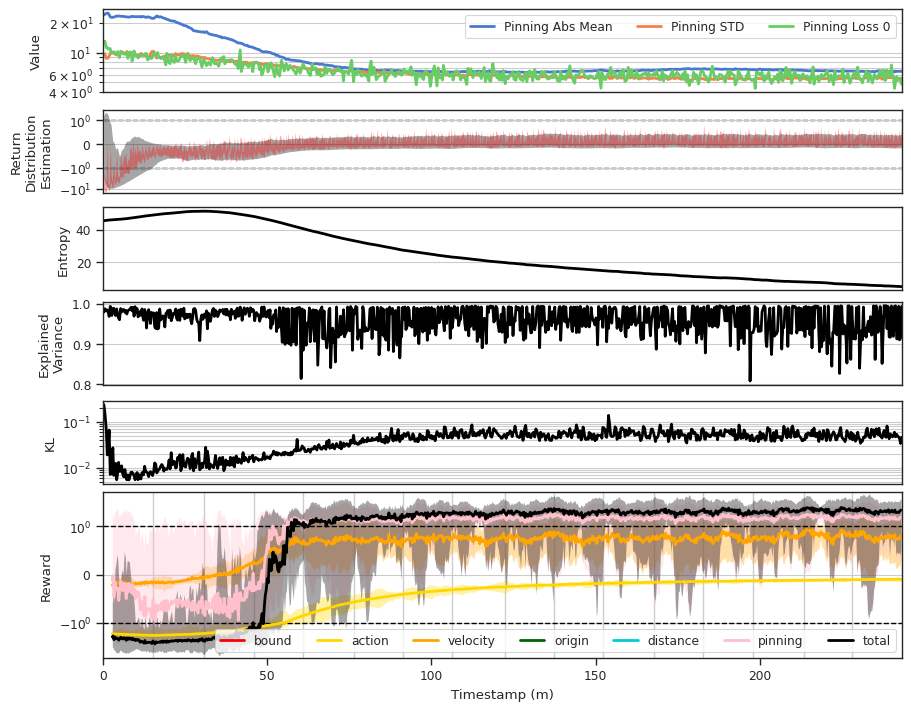

In [10]:
# Parameters
use_smooth = True
only_ends = False
omit_zero = True
symlog = True
linthresh = 1e0
step_lines = 50

# Melt functions
def melt_rewards_rollout(df):
    df = df[['Timestamp', 'bound', 'action', 'velocity', 'origin', 'distance', 'pinning', 'Reward']].rename(
            columns={'Reward': 'total'}
        ).melt(
            id_vars='Timestamp', var_name='Reward',
            value_name='Value')
    return df

def melt_rewards_update(df):
    df = df[[
        'Timestamp', 'Iterations', 'Log STD', 'PPO',
        'critic', 'entropy', 'KL']].melt(
            id_vars='Timestamp', var_name='Parameter',
            value_name='Value')
    return df

# Filter function
def filter_zero(df):
    df.loc[df['Value'] == 0, 'Value'] = pd.NA
    return df
if not omit_zero: filter_zero = lambda x: x

def smooth(df_col, episode_len=((2**6+2**7)/2)/.1, window=10):
    # Replace NAN with zero
    df_col = df_col.fillna(0)
    # Reward per timestep
    reward_per_timestep = (
        episode_len
        * df_col.rolling(window).sum().reset_index(drop=True)  # , min_periods=1
        / df_rollout['Timesteps'].rolling(window).sum().reset_index(drop=True))  # , min_periods=1
    # Replace zeros with NAN
    if omit_zero: reward_per_timestep.loc[reward_per_timestep==0] = pd.NA
    return reward_per_timestep
if not use_smooth: smooth = lambda x: x

# Line plot function
def gap_plot(df, x, y, hue, palette, ax, legend=True, plot_type='line', **kwargs):
    # sns.lineplot(
    #     melt_rewards(group_policy(event_filter('Rollout'))),
    #     x='Timestamp', y='Value', hue='Reward', palette=reward_colors,
    #     lw=2, ax=ax)
    for h in df[hue].unique():
        df_filt = df.loc[df[hue]==h]
        smoothed_y = smooth(df_filt[y])
        if plot_type == 'line':
            ax.plot(df_filt[x], smoothed_y, color=palette[h], label=h if legend else None, **kwargs)
            # Plot new best
            # new_best = np.zeros_like(df_filt[y].to_numpy(), dtype=bool); best = -np.inf
            # for i, v in enumerate(smoothed_y.to_numpy()):
            #     if v > best: best = v; new_best[i] = True
            # ax.scatter(df_filt.loc[new_best, x], smoothed_y.loc[new_best], marker='|', s=4, color='red', zorder=2)
        elif plot_type == 'scatter':
            ax.scatter(df_filt[x], smoothed_y, color=palette[h], label=h if legend else None, **kwargs)

# Data
df_raw = melt_rewards_rollout(event_filter(df_records, 'Rollout'))
df_mean = melt_rewards_rollout(group_policy(event_filter(df_records, 'Rollout'), agg='mean'))
df_std = melt_rewards_rollout(group_policy(event_filter(df_records, 'Rollout'), agg='std'))
df_min = melt_rewards_rollout(group_policy(event_filter(df_records, 'Rollout'), agg='min'))
df_max = melt_rewards_rollout(group_policy(event_filter(df_records, 'Rollout'), agg='max'))
df_rollout = group_policy(event_filter(df_records, 'Rollout'), agg='mean')
df_update = group_policy(event_filter(df_records, 'Update'), agg='mean')

# Plot
fig = plt.figure(figsize=(9, 7), layout='constrained')
ax_loss = plt.subplot2grid((7, 2), (5, 0), 2, 2, fig)
ax_kl = plt.subplot2grid((7, 2), (4, 0), 1, 2, fig, sharex=ax_loss)
ax_ev = plt.subplot2grid((7, 2), (3, 0), 1, 2, fig, sharex=ax_loss)
ax_entrop = plt.subplot2grid((7, 2), (2, 0), 1, 2, fig, sharex=ax_loss)
ax_moving = plt.subplot2grid((7, 2), (1, 0), 1, 2, fig, sharex=ax_loss)
ax_pinning = plt.subplot2grid((7, 2), (0, 0), 1, 2, fig, sharex=ax_loss)
# TODO: Maybe try timesteps on x?

# Pinning
i = 0
colnames = [col for col in df_update.columns if col.startswith('Pinning')]
for colname in colnames:
    if colname.startswith('Pinning Mean'): continue
    Y = df_update[colname].dropna()
    X = df_update['Timestamp'].loc[Y.index]
    # Y = smooth(Y)
    ax_pinning.plot(
        X, Y, lw=2, label=colname)  #  if not colname.startswith('Pinning Mean') else colname+' (ABS)'
ax_pinning.set_ylabel('Value')
# if symlog:
#     ax_pinning.set_yscale('symlog', base=10, linthresh=linthresh)
#     ax_pinning.axhline(y=linthresh, color='black', lw=1, ls='--', zorder=1.1)
# ax_pinning.set_ylim(bottom=0)
ax_pinning.set_yscale('log')
ax_pinning.legend(loc='upper right', ncols=4)
# ax_pinning.set_ylim(top=1)
ax_pinning.tick_params(axis='x', which='both', bottom=False)
ax_pinning.grid(axis='y', which='both', visible=True)
plt.setp(ax_pinning.get_xticklabels(), visible=False)

# Moving returns
ax_moving.fill_between(
        df_update['Timestamp'],
        df_update['Moving Return Mean']-df_update['Moving Return STD'],
        df_update['Moving Return Mean']+df_update['Moving Return STD'], lw=0, color='black', alpha=.35)
ax_moving.fill_between(
        df_update['Timestamp'],
        df_update['Return Mean']-df_update['Return STD'],
        df_update['Return Mean']+df_update['Return STD'], lw=0, color='red', alpha=.35)
ax_moving.set_ylabel('Return\nDistribution\nEstimation')
ax_moving.grid(axis='y', which='both', visible=True)
ax_moving.tick_params(axis='x', which='both', bottom=False)
plt.setp(ax_moving.get_xticklabels(), visible=False)
if symlog:
    ax_moving.set_yscale('symlog', base=10, linthresh=linthresh)
    for s in (-1, 1): ax_moving.axhline(y=s*linthresh, color='black', lw=1, ls='--', zorder=.2)

# Entropy
ax_entrop.plot(
    df_update['Timestamp'], -df_update['entropy'], lw=2, color='black')
ax_entrop.set_ylabel('Entropy')
ax_entrop.grid(axis='y', which='both', visible=True)
ax_entrop.tick_params(axis='x', which='both', bottom=False)
plt.setp(ax_entrop.get_xticklabels(), visible=False)

# Explained Variance
ax_ev.plot(
    df_update['Timestamp'], df_update['Explained Variance'], lw=2, color='black')
ax_ev.set_ylabel('Explained\nVariance')
ax_ev.grid(axis='y', which='both', visible=True)
ax_ev.tick_params(axis='x', which='both', bottom=False)
plt.setp(ax_ev.get_xticklabels(), visible=False)
# ax_ev.set_ylim(-1, 1)

# KL
df_update = group_policy(event_filter(df_records, 'Update'), agg='mean')
ax_kl.plot(
    df_update['Timestamp'], df_update['KL'], lw=2, color='black')
kl_target = .3
# ax_kl.axhline(y=kl_target, ls='--', lw=1, color='black')
# ax_kl.axhline(y=kl_target*1.5, ls='--', lw=1, color='black')
# ax_kl.axhline(y=kl_target/1.5, ls='--', lw=1, color='black')
ax_kl.set_yscale('log')
ax_kl.set_ylabel('KL')
ax_kl.grid(axis='y', which='both', visible=True)
ax_kl.tick_params(axis='x', which='both', bottom=False)
plt.setp(ax_kl.get_xticklabels(), visible=False)
# ax_kl.tick_params(axis='x', which='both', bottom=False)

# Shading
for h in df_raw['Reward'].unique():
    mask = df_min['Reward'] == h
    # Max min
    x = df_mean.loc[mask, 'Timestamp']
    # lower, upper = df_min.loc[mask, 'Value'], df_max.loc[mask, 'Value']  # Max min
    coeff = 1  # 1.96
    lower, upper = (
        smooth(df_mean.loc[mask, 'Value']
        - coeff*df_std.loc[mask, 'Value']),
        smooth(df_mean.loc[mask, 'Value']
        + coeff*df_std.loc[mask, 'Value']))  # STD
    # Filter zeros
    zero_mask = (lower == 0) * (upper == 0)
    lower[zero_mask] = upper[zero_mask] = pd.NA
    # Fill
    ax_loss.fill_between(
        x, lower, upper, lw=0, color=reward_colors[h], alpha=.35)
# Mean line
gap_plot(
    filter_zero(df_mean), x='Timestamp', y='Value', hue='Reward',
    palette=reward_colors, lw=2, ax=ax_loss, plot_type='line')
# Step lines
for t in df_mean.loc[df_mean['Reward']=='total', 'Timestamp'][step_lines::step_lines]:
    ax_loss.axvline(t, color='black', alpha=.2, ls='-', lw=1, zorder=.2)
# Stages
for i, r in event_filter(df_records, 'Advance Stage').iterrows():
    ax_loss.axvline(r['Timestamp'], color='black', ls=':', lw=2, zorder=.2)
# Formatting
# sns.despine(ax=ax_loss)
ax_loss.set(xlabel='Timestamp (m)', ylabel='Reward')
ax_loss.set_xlim(left=0, right=np.max([span_dict_squashed[k][-1][1] for k in span_dict]))
if symlog:  # and False
    ax_loss.set_yscale('symlog', base=10, linthresh=linthresh)
    for s in (-1, 1): ax_loss.axhline(y=s*linthresh, color='black', lw=1, ls='--', zorder=1.1)
# ax_loss.axhline(y=0, color='black', lw=1, ls='-', zorder=.2)
# for k in span_dict_squashed.keys():
#     if k not in event_colors: continue
#     for xmin, xmax in span_dict_squashed[k]: ax_loss.axvspan(xmin, xmax, color=event_colors[k], alpha=.3, lw=0, zorder=.1)
# import matplotlib as mpl
# ax_loss.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
# ticks = [-10, -4, -2, 0, 2, 4, 10]
# ax_loss.set(yticks=ticks, yticklabels=ticks)
ax_loss.grid(axis='y', which='both', visible=True)
ax_loss.legend(loc='lower right', ncols=8)

# Early stopping based on KL (MAYBE DO BASED ON LOG STD, KL, AND RWD?)
count = 0; es_timestep = None; lapses = 5; es_threshold = 1e-3; min_updates = 500
for i, r in group_policy(event_filter(df_records, 'Update')).iterrows():
    if i < min_updates: continue
    count = count + 1 if r['KL'] < es_threshold else 0
    if count >= lapses:
        es_timestep = r['Timestamp']
        break
if es_timestep is not None: ax_loss.axvline(x=es_timestep, ls=':', color='red')
# ax_kl.axhline(y=es_threshold, ls='--', lw=1, color='red')

# Display
# ax1.axhline(y=.03)
fig.show()


In [11]:
try:
    # Best total
    smoothed = smooth(df_mean.loc[df_mean['Reward']=='total', 'Value']).reset_index(drop=True)
    num_iters = smoothed.shape[0]
    best_iter = smoothed.index[smoothed.argmax()]
    best_score = smoothed.loc[best_iter]
    print(f'Best total {best_iter+1}/{num_iters} ({best_score:.2f})')
    # Best vel
    smoothed = smooth(df_mean.loc[df_mean['Reward']=='velocity', 'Value']).reset_index(drop=True)
    best_iter = smoothed.index[smoothed.argmax()]
    best_score = smoothed.loc[best_iter]
    print(f'Best vel {best_iter+1}/{num_iters} ({best_score:.2f})')
    # Best pinning
    smoothed = smooth(df_mean.loc[df_mean['Reward']=='pinning', 'Value']).reset_index(drop=True)
    best_iter = smoothed.index[smoothed.argmax()]
    best_score = smoothed.loc[best_iter]
    print(f'Best pinning {best_iter+1}/{num_iters} ({best_score:.2f})')
except: pass


Best total 740/800 (2.74)
Best vel 705/800 (0.93)
Best pinning 740/800 (1.93)


# Time Plot

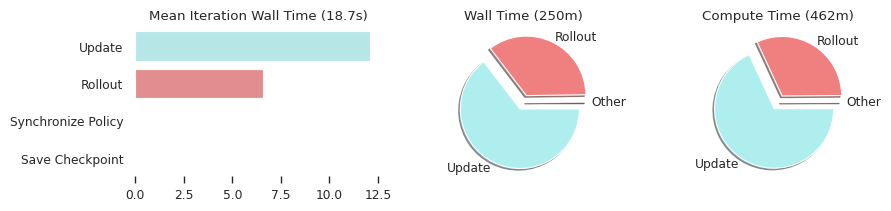

In [12]:
# Processing functions
def group_small(df):
    mask = (df['Time'] / df['Time'].sum()) < .02
    if mask.sum() > 0:
        other_row = df.loc[mask].sum()
        df = df.loc[~mask].copy()
        df.loc['Other'] = other_row
    return df

# Get times
span_times = {k: timestamp_divisor*np.sum([v2[1]-v2[0] for v2 in v1]) for k, v1 in span_dict_squashed.items()}
df_walltime = pd.DataFrame(span_times.values(), index=span_times.keys(), columns=['Time'])
df_walltime.index.name = 'Event Type'
df_walltime = df_walltime.loc[df_walltime['Time'] != 0].dropna()
df_walltime['Mean Time'] = df_walltime.apply(lambda r: r['Time'] / len(span_dict_squashed[r.name]), axis=1)
df_walltime['Iteration Time'] = df_walltime.apply(lambda r: r['Time'] / len(span_dict_squashed['Update']), axis=1)
df_comptime = df_records.groupby('Event Type').sum()[['Time']]
df_comptime = df_comptime.loc[df_comptime['Time'] != 0].dropna()
df_comptime['Mean Time'] = df_comptime.apply(lambda r: r['Time'] / len(span_dict_squashed[r.name]), axis=1)
df_comptime['Iteration Time'] = df_comptime.apply(lambda r: r['Time'] / len(span_dict_squashed['Update']), axis=1)

# Plot function
def plot_pie(df, ax):
    labels = df.index.to_numpy()
    sizes = df['Time'].to_numpy()
    colors = [event_colors[l] for l in labels]
    explode = .3 * np.log(1+sizes) / np.log(1+sizes).sum()
    ax.pie(
        sizes, explode=explode, labels=labels, colors=colors,  # autopct='%1.1f%%',
        shadow=True, startangle=0, counterclock=False, rotatelabels=False)

# Plot
fig = plt.figure(figsize=(9, 2), layout='constrained')
ax1 = plt.subplot2grid((1, 3), (0, 1), 1, 1, fig=fig)
plot_pie(group_small(df_walltime.sort_values('Time', ascending=False)), ax1)
ax1.set(title=f'Wall Time ({df_walltime.sum()["Time"]/60:.0f}m)')
ax2 = plt.subplot2grid((1, 3), (0, 2), 1, 1, fig=fig)
plot_pie(group_small(df_comptime.sort_values('Time', ascending=False)), ax2)
ax2.set(title=f'Compute Time ({df_comptime.sum()["Time"]/60:.0f}m)')
ax3 = plt.subplot2grid((1, 3), (0, 0), 1, 1, fig=fig)
sns.barplot(
    df_walltime.sort_values('Iteration Time', ascending=False), y='Event Type', x='Iteration Time', hue='Event Type',
    palette=event_colors, ax=ax3)
sns.despine(left=True, bottom=True, ax=ax3)
ax3.set(title=f'Mean Iteration Wall Time ({df_walltime.sum()["Iteration Time"]:.1f}s)', xlabel=None, ylabel=None)
ax3.tick_params(axis='y', which='major', left=False)
fig.show()


In [13]:
rate_per_hour = 1.5
num_iters = 800
comptime_per_iter = df_comptime['Mean Time'].sum() / 60**2
walltime_per_iter = df_walltime['Mean Time'].sum() / 60**2
time_estimation = num_iters * walltime_per_iter
cost_estimation = num_iters * comptime_per_iter * rate_per_hour
print(f'~${cost_estimation:.2f} in {time_estimation:.2f} hours per {num_iters} iterations')


~$11.60 in 4.20 hours per 800 iterations


In [14]:
# # Format
# df_rollout = group_policy(event_filter(df_records, 'Rollout'), agg='mean')
# df_update = group_policy(event_filter(df_records, 'Update'), agg='mean')
# df_combined = df_rollout.join(df_update, rsuffix='_update')

# # Plot
# fig = plt.figure(figsize=(6, 6), layout='constrained')
# ax1 = plt.subplot2grid((1, 1), (0, 0), 1, 1, fig=fig)
# sns.scatterplot(df_combined, x='Log STD', y='distance', hue='Timestamp', ax=ax1)
# ax1.set_yscale('symlog')
# ax1.invert_xaxis()
# fig.show()
